In [35]:
# Flood Prediction Analysis
# Data Science Project: Predicting Road Flooding Based on Weather Conditions
# 
# This notebook analyzes flood data and weather conditions to build a predictive model
# for identifying which roads are likely to be flooded given weather conditions.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

Libraries imported successfully!
Pandas version: 2.3.2
NumPy version: 2.3.3


In [36]:
# Load the datasets
print("Loading datasets...")

# Load flood data (phase 1 - already processed with road sectors)
flood_df = pd.read_csv("../data/interim/flooded_roads_phase1.csv")
print(f"Flood data shape: {flood_df.shape}")

# Load weather data (hourly)
weather_df = pd.read_csv("../data/interim/weather_all_months_hourly.csv")
print(f"Weather data shape: {weather_df.shape}")

# Load original MMDA data for reference
mmda_df = pd.read_csv("../data/interim/mmda_flooded_roads.csv", on_bad_lines="skip")
print(f"MMDA data shape: {mmda_df.shape}")

print("\nDatasets loaded successfully!")

Loading datasets...
Flood data shape: (387, 7)
Weather data shape: (76467, 21)
MMDA data shape: (602, 6)

Datasets loaded successfully!


In [37]:
# Data Overview and Exploration
print("=== FLOOD DATA OVERVIEW ===")
print(f"Flood data shape: {flood_df.shape}")
print(f"Date range: {flood_df['datetime'].min()} to {flood_df['datetime'].max()}")
print(f"Number of unique roads: {flood_df['Location'].nunique()}")
print(f"Number of road sectors: {flood_df['Road_Sector'].nunique()}")
print(f"Number of cities: {flood_df['City'].nunique()}")
print("\nFlood data info:")
flood_df.info()
print("\nFlood data sample:")
flood_df.head()

=== FLOOD DATA OVERVIEW ===
Flood data shape: (387, 7)
Date range: 2025-06-06 15:16:00 to 2025-09-12 15:14:00
Number of unique roads: 173
Number of road sectors: 20
Number of cities: 8

Flood data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387 entries, 0 to 386
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        387 non-null    int64 
 1   City              387 non-null    object
 2   Location          387 non-null    object
 3   Flood Type/Depth  387 non-null    object
 4   Passability       387 non-null    object
 5   datetime          387 non-null    object
 6   Road_Sector       387 non-null    object
dtypes: int64(1), object(6)
memory usage: 21.3+ KB

Flood data sample:


,Unnamed: 0,City,Location,Flood Type/Depth,Passability,datetime,Road_Sector
0,0,Quezon City,EDSA After Quezon Ave. Flyover NB,Gutter Deep,Passable to all vehicles,2025-09-12 15:14:00,EDSA_QC_CENTRAL
1,1,Quezon City,EDSA Quezon Ave. service road NB,Gutter Deep,Passable to all vehicles,2025-09-12 15:14:00,EDSA_QC_CENTRAL
2,2,Quezon City,EDSA Aurora Tunnel NB,Subsided,Passable to all vehicles,2025-09-12 14:54:00,EDSA_QC_BOUNDARY
3,3,Quezon City,EDSA before Kamuning flyover SB,Subsided,Passable to all vehicles,2025-09-12 14:55:00,EDSA_QC_SOUTH
4,4,Quezon City,EDSA After Quezon Ave. Flyover NB,Gutter Deep,Passable to all vehicles,2025-09-12 14:50:00,EDSA_QC_CENTRAL


In [38]:
# Weather Data Overview
print("=== WEATHER DATA OVERVIEW ===")
print(f"Weather data shape: {weather_df.shape}")
print(f"Date range: {weather_df['datetime'].min()} to {weather_df['datetime'].max()}")
print(f"Number of cities: {weather_df['City'].nunique()}")
print(f"Cities: {weather_df['City'].unique()}")
print("\nWeather data info:")
weather_df.info()
print("\nWeather data sample:")
weather_df.head()

=== WEATHER DATA OVERVIEW ===
Weather data shape: (76467, 21)
Date range: 2025-01-01 00:06:30+08:00 to 2025-09-29 12:04:15+08:00
Number of cities: 14
Cities: ['Caloocan City' 'Marikina City' 'Las Piñas City' 'Makati City'
 'Malabon City' 'Mandaluyong City' 'Manila City' 'Navotas City'
 'Parañaque City' 'Pasig City' 'Quezon City' 'San Juan City' 'Taguig City'
 'Valenzuela City']

Weather data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76467 entries, 0 to 76466
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   visibility           76293 non-null  float64
 1   datetime             76467 non-null  object 
 2   main.temp            76467 non-null  float64
 3   main.feels_like      76467 non-null  float64
 4   main.temp_min        76467 non-null  float64
 5   main.temp_max        76467 non-null  float64
 6   main.pressure        76467 non-null  float64
 7   main.humidity        76467 non-null

,visibility,datetime,main.temp,main.feels_like,main.temp_min,main.temp_max,main.pressure,main.humidity,main.sea_level,main.grnd_level,...,wind.deg,wind.gust,clouds.all,sys.sunrise,sys.sunset,weather.main,weather.description,City,rain1h,hour
0,10000.0,2025-08-01 00:00:55+08:00,29.03,35.05,27.83,29.48,1008.0,81.0,1008.0,1011.0,...,217.0,6.71,20.0,2025-08-01 05:39:14+08:00,2025-08-01 18:25:35+08:00,Clouds,few clouds,Caloocan City,NaN,00:00:00
1,10000.0,2025-07-31 23:58:59+08:00,29.19,35.05,27.79,29.43,1008.0,79.0,1008.0,1000.0,...,149.0,4.02,20.0,2025-08-01 05:38:43+08:00,2025-08-01 18:25:02+08:00,Clouds,few clouds,Marikina City,NaN,23:00:00
2,10000.0,2025-08-01 00:02:14+08:00,28.15,32.48,27.77,29.41,1008.0,80.0,1008.0,1004.0,...,220.0,NaN,20.0,2025-08-01 05:39:27+08:00,2025-08-01 18:25:14+08:00,Clouds,few clouds,Las Piñas City,NaN,00:00:00
3,10000.0,2025-08-01 00:00:03+08:00,28.74,33.83,27.71,29.36,1008.0,79.0,1008.0,1007.0,...,149.0,4.02,20.0,2025-08-01 05:39:06+08:00,2025-08-01 18:25:11+08:00,Clouds,few clouds,Makati City,NaN,00:00:00
4,10000.0,2025-08-01 00:02:27+08:00,27.45,32.19,27.45,27.45,1009.0,91.0,1009.0,984.0,...,176.0,7.32,91.0,2025-08-01 05:41:56+08:00,2025-08-01 18:31:06+08:00,Clouds,overcast clouds,Malabon City,NaN,00:00:00


In [39]:
# Data Preprocessing and Cleaning
print("=== DATA PREPROCESSING ===")

# Convert datetime columns
flood_df['datetime'] = pd.to_datetime(flood_df['datetime']).dt.tz_localize('Asia/Singapore')
weather_df['datetime'] = pd.to_datetime(weather_df['datetime'])

# Handle rain1h column - convert to numeric, fill NaN with 0
weather_df['rain1h'] = pd.to_numeric(weather_df['rain1h'], errors='coerce').fillna(0)

# Create flood severity mapping
flood_depth_map = {
    'Subsided': 0,
    'Half Gutter Deep': 4,
    'Gutter Deep': 8,
    'Above Gutter Deep': 10,
    'Half Knee Deep': 10,
    'Half Tire Deep': 13,
    'Knee Deep': 19,
    'Tire Deep': 26,
    'Knee-Waist Deep': 25,
    'Waist Deep': 37,
    'Chest Deep': 45,
    '4 Feet Deep': 48,
    '6 Feet Deep': 72,
}

flood_df['depth_in'] = flood_df['Flood Type/Depth'].map(flood_depth_map)

print("Data preprocessing completed!")
print(f"Flood severity distribution:")
print(flood_df['depth_in'].value_counts().sort_index())

=== DATA PREPROCESSING ===
Data preprocessing completed!
Flood severity distribution:
depth_in
0      48
4       4
8     217
10     35
13      9
19     55
25      1
26      3
37     13
48      1
72      1
Name: count, dtype: int64


=== ROAD SECTOR ANALYSIS ===
Number of unique road sectors: 20
Road sectors: ['C5_KATIPUNAN', 'C5_LUZON', 'COMMONWEALTH AVENUE', 'DR. SANTOS AVENUE', 'EDSA_CALOOCAN', 'EDSA_MAKATI', 'EDSA_MANDALUYONG', 'EDSA_PASAY', 'EDSA_QC_BOUNDARY', 'EDSA_QC_CENTRAL', 'EDSA_QC_NORTH', 'EDSA_QC_SOUTH', 'ESPAÑA BOULEVARD', 'MACARTHUR HIGHWAY', 'OSMEÑA HIGHWAY', 'QUEZON AVENUE', 'QUIRINO AVENUE', 'RECTO AVENUE', 'ROXAS BOULEVARD', 'TAFT AVENUE']

Top 10 most flooded road sectors:
Road_Sector
TAFT AVENUE            56
COMMONWEALTH AVENUE    51
EDSA_QC_NORTH          38
ROXAS BOULEVARD        31
ESPAÑA BOULEVARD       30
EDSA_MANDALUYONG       24
C5_KATIPUNAN           24
EDSA_QC_SOUTH          24
DR. SANTOS AVENUE      23
EDSA_QC_CENTRAL        20
Name: count, dtype: int64


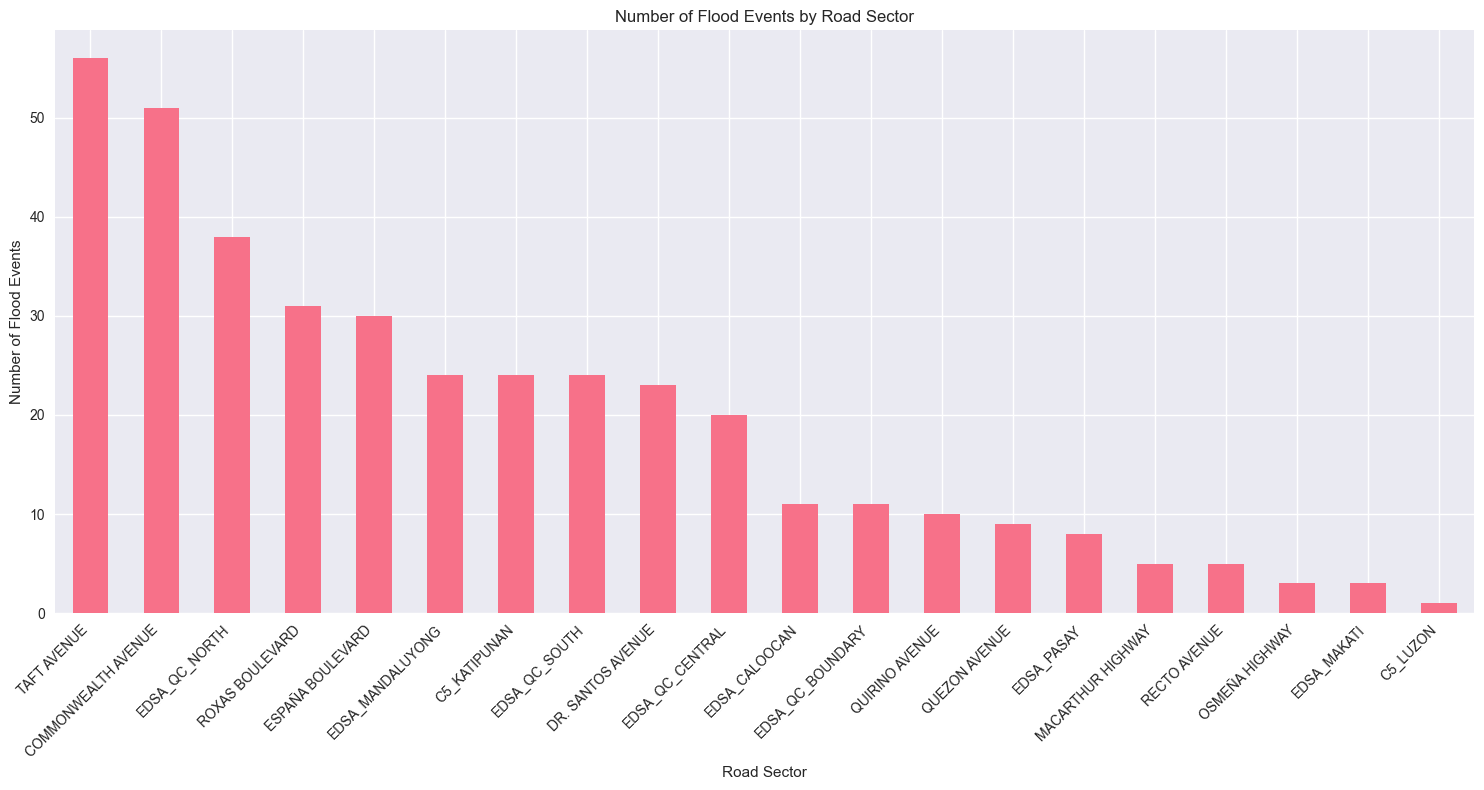

In [40]:
# Road Sector Analysis
print("=== ROAD SECTOR ANALYSIS ===")
print(f"Number of unique road sectors: {flood_df['Road_Sector'].nunique()}")
print(f"Road sectors: {sorted(flood_df['Road_Sector'].unique())}")

# Count floods per road sector
sector_counts = flood_df['Road_Sector'].value_counts()
print(f"\nTop 10 most flooded road sectors:")
print(sector_counts.head(10))

# Visualize flood distribution by road sector
plt.figure(figsize=(15, 8))
sector_counts.plot(kind='bar')
plt.title('Number of Flood Events by Road Sector')
plt.xlabel('Road Sector')
plt.ylabel('Number of Flood Events')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [41]:
# Merge Road Sector Information - Get Worst Data at Each Time
print("=== MERGING ROAD SECTOR DATA ===")

# Group by datetime and road sector to get the worst flood condition at each time
def get_worst_flood_condition(group):
    """Get the worst flood condition for each road sector at each time"""
    # Sort by flood severity (descending) and take the first (worst) one
    return group.loc[group['depth_in'].idxmax()]

# Group by datetime and road sector, then get worst condition
flood_aggregated = flood_df.groupby(['datetime', 'Road_Sector']).apply(
    get_worst_flood_condition, include_groups=False
).reset_index()

print(f"Original flood records: {len(flood_df)}")
print(f"Aggregated flood records: {len(flood_aggregated)}")
print(f"Unique datetime-road sector combinations: {flood_aggregated.groupby(['datetime', 'Road_Sector']).ngroups}")

# Create binary flood indicator (1 if any flood, 0 if subsided)
flood_aggregated['is_flooded'] = (flood_aggregated['depth_in'] > 0).astype(int)

print(f"\nFlood status distribution:")
print(flood_aggregated['is_flooded'].value_counts())
print(f"Flood rate: {flood_aggregated['is_flooded'].mean():.2%}")


=== MERGING ROAD SECTOR DATA ===
Original flood records: 387
Aggregated flood records: 202
Unique datetime-road sector combinations: 202

Flood status distribution:
is_flooded
1    172
0     30
Name: count, dtype: int64
Flood rate: 85.15%


In [42]:
# Normalize Data Hourly
print("=== NORMALIZING DATA HOURLY ===")

# Round flood data to nearest hour
flood_aggregated['datetime_hour'] = flood_aggregated['datetime'].dt.floor('H')

# Round weather data to nearest hour
weather_df['datetime_hour'] = weather_df['datetime'].dt.floor('H')

def fast_transform(series):
    return series.value_counts().idxmax() if not series.empty else 'Unknown'

# Aggregate weather data by hour and city (take mean for continuous variables)
weather_hourly = weather_df.groupby(['datetime_hour', 'City']).agg({
    'main.temp': 'mean',
    'main.feels_like': 'mean',
    'main.temp_min': 'min',
    'main.temp_max': 'max',
    'main.pressure': 'mean',
    'main.humidity': 'mean',
    'wind.speed': 'mean',
    'wind.gust': 'mean',
    'clouds.all': 'mean',
    'rain1h': 'sum',  # Sum rain over the hour
    'weather.main': fast_transform,
    'weather.description': fast_transform 
}).reset_index()

print(f"Weather data shape after hourly aggregation: {weather_hourly.shape}")
print(f"Date range: {weather_hourly['datetime_hour'].min()} to {weather_hourly['datetime_hour'].max()}")

# Show sample of hourly weather data
print("\nSample of hourly weather data:")
weather_hourly.head()


=== NORMALIZING DATA HOURLY ===
Weather data shape after hourly aggregation: (76460, 14)
Date range: 2025-01-01 00:00:00+08:00 to 2025-09-29 12:00:00+08:00

Sample of hourly weather data:


,datetime_hour,City,main.temp,main.feels_like,main.temp_min,main.temp_max,main.pressure,main.humidity,wind.speed,wind.gust,clouds.all,rain1h,weather.main,weather.description
0,2025-01-01 00:00:00+08:00,Caloocan City,26.83,29.98,26.12,27.30,1011.0,87.0,3.03,3.16,56.0,0.00,Clouds,broken clouds
1,2025-01-01 00:00:00+08:00,Las Piñas City,26.72,29.95,26.06,27.24,1011.0,90.0,3.58,3.58,65.0,0.00,Clouds,broken clouds
2,2025-01-01 00:00:00+08:00,Makati City,27.00,30.43,26.00,27.18,1011.0,87.0,1.79,3.13,55.0,0.00,Clouds,broken clouds
3,2025-01-01 00:00:00+08:00,Malabon City,25.52,26.29,25.52,25.52,1011.0,83.0,1.78,1.79,75.0,0.00,Clouds,broken clouds
4,2025-01-01 00:00:00+08:00,Mandaluyong City,26.88,30.11,26.01,27.19,1011.0,87.0,3.68,4.71,53.0,0.12,Rain,light rain


In [43]:
# Create City-Road Sector Mapping
print("=== CREATING CITY-ROAD SECTOR MAPPING ===")

# Create a mapping of cities to road sectors based on flood data
city_road_mapping = flood_aggregated.groupby('City')['Road_Sector'].apply(list).to_dict()

# Also create reverse mapping
road_city_mapping = {}
for city, roads in city_road_mapping.items():
    for road in roads:
        if road not in road_city_mapping:
            road_city_mapping[road] = []
        road_city_mapping[road].append(city)

print("City to Road Sector mapping:")
for city, roads in city_road_mapping.items():
    print(f"{city}: {roads}")

print(f"\nNumber of unique road sectors: {len(road_city_mapping)}")
print(f"Number of cities with flood data: {len(city_road_mapping)}")


=== CREATING CITY-ROAD SECTOR MAPPING ===
City to Road Sector mapping:
Caloocan City: ['MACARTHUR HIGHWAY', 'MACARTHUR HIGHWAY', 'EDSA_QC_NORTH', 'EDSA_QC_NORTH']
Makati City: ['EDSA_MAKATI', 'EDSA_MAKATI', 'EDSA_MAKATI', 'OSMEÑA HIGHWAY', 'OSMEÑA HIGHWAY', 'OSMEÑA HIGHWAY']
Mandaluyong City: ['EDSA_MANDALUYONG', 'EDSA_MANDALUYONG', 'EDSA_MANDALUYONG', 'EDSA_MANDALUYONG', 'EDSA_MANDALUYONG', 'EDSA_MANDALUYONG', 'EDSA_MANDALUYONG', 'EDSA_MANDALUYONG', 'EDSA_MANDALUYONG', 'EDSA_MANDALUYONG', 'EDSA_MANDALUYONG', 'EDSA_MANDALUYONG', 'EDSA_MANDALUYONG', 'EDSA_MANDALUYONG', 'EDSA_MANDALUYONG', 'EDSA_MANDALUYONG', 'EDSA_MANDALUYONG', 'EDSA_MANDALUYONG']
Manila City: ['ESPAÑA BOULEVARD', 'ESPAÑA BOULEVARD', 'ESPAÑA BOULEVARD', 'TAFT AVENUE', 'ESPAÑA BOULEVARD', 'TAFT AVENUE', 'ESPAÑA BOULEVARD', 'TAFT AVENUE', 'ROXAS BOULEVARD', 'TAFT AVENUE', 'ESPAÑA BOULEVARD', 'ESPAÑA BOULEVARD', 'ESPAÑA BOULEVARD', 'QUIRINO AVENUE', 'RECTO AVENUE', 'ROXAS BOULEVARD', 'TAFT AVENUE', 'ESPAÑA BOULEVARD', 'QUI

In [45]:
# Merge Flood and Weather Data
print("=== MERGING FLOOD AND WEATHER DATA ===")

# Create a comprehensive dataset by merging flood and weather data
# For each flood record, we'll get the weather data for the corresponding city and time

# First, let's create a complete dataset with all possible combinations
all_combinations = []
for city in weather_hourly['City'].unique():
    city_roads = city_road_mapping.get(city, [])
    for road in city_roads:
        city_weather = weather_hourly[weather_hourly['City'] == city].copy()
        city_weather['Road_Sector'] = road
        all_combinations.append(city_weather)

# Combine all combinations
weather_expanded = pd.concat(all_combinations, ignore_index=True)

print(f"Weather data expanded shape: {weather_expanded.shape}")

# Merge with flood data
merged_data = weather_expanded.merge(
    flood_aggregated[['datetime_hour', 'Road_Sector', 'is_flooded', 'depth_in']], 
    on=['datetime_hour', 'Road_Sector'], 
    how='left'
)

# Fill missing flood data with 0 (no flood)
merged_data['is_flooded'] = merged_data['is_flooded'].fillna(0).astype(int)
merged_data['depth_in'] = merged_data['depth_in'].fillna(0).astype(int)

print(f"Final merged dataset shape: {merged_data.shape}")
print(f"Flood rate in merged data: {merged_data['is_flooded'].mean():.2%}")

# Show sample of merged data
print("\nSample of merged data:")
merged_data.head()


=== MERGING FLOOD AND WEATHER DATA ===
Weather data expanded shape: (1018548, 15)
Final merged dataset shape: (1019096, 17)
Flood rate in merged data: 0.20%

Sample of merged data:


,datetime_hour,City,main.temp,main.feels_like,main.temp_min,main.temp_max,main.pressure,main.humidity,wind.speed,wind.gust,clouds.all,rain1h,weather.main,weather.description,Road_Sector,is_flooded,depth_in
0,2025-01-01 00:00:00+08:00,Caloocan City,26.83,29.98,26.12,27.30,1011.0,87.0,3.03,3.16,56.0,0.00,Clouds,broken clouds,MACARTHUR HIGHWAY,0,0
1,2025-01-01 02:00:00+08:00,Caloocan City,25.65,26.62,25.57,25.66,1010.0,90.0,0.89,2.24,71.0,0.00,Clouds,broken clouds,MACARTHUR HIGHWAY,0,0
2,2025-01-01 04:00:00+08:00,Caloocan City,25.71,26.76,25.57,26.03,1010.0,93.0,0.00,NaN,100.0,0.41,Rain,light rain,MACARTHUR HIGHWAY,0,0
3,2025-01-01 06:00:00+08:00,Caloocan City,25.77,26.78,25.57,26.19,1010.0,91.0,0.89,3.58,75.0,0.00,Clouds,broken clouds,MACARTHUR HIGHWAY,0,0
4,2025-01-01 08:00:00+08:00,Caloocan City,26.20,26.20,25.57,26.21,1012.0,90.0,1.82,2.38,100.0,0.00,Clouds,overcast clouds,MACARTHUR HIGHWAY,0,0


In [46]:
# Feature Engineering
print("=== FEATURE ENGINEERING ===")

# Create time-based features
merged_data['hour'] = merged_data['datetime_hour'].dt.hour
merged_data['day_of_week'] = merged_data['datetime_hour'].dt.dayofweek
merged_data['month'] = merged_data['datetime_hour'].dt.month
merged_data['is_weekend'] = (merged_data['day_of_week'] >= 5).astype(int)

# Create weather-based features
merged_data['temp_range'] = merged_data['main.temp_max'] - merged_data['main.temp_min']
merged_data['is_raining'] = (merged_data['rain1h'] > 0).astype(int)
merged_data['heavy_rain'] = (merged_data['rain1h'] > 2.5).astype(int)  # Heavy rain threshold
merged_data['very_heavy_rain'] = (merged_data['rain1h'] > 5.0).astype(int)  # Very heavy rain threshold

# Create rolling averages for weather features (lag features)
merged_data = merged_data.sort_values(['Road_Sector', 'datetime_hour'])

# Create lag features for rain (previous hours)
for lag in [1, 2, 3, 6, 12, 24]:
    merged_data[f'rain_lag_{lag}h'] = merged_data.groupby('Road_Sector')['rain1h'].shift(lag).fillna(0)
    merged_data[f'cumulative_rain_{lag}h'] = merged_data.groupby('Road_Sector')['rain1h'].rolling(
        window=lag, min_periods=1
    ).sum().reset_index(0, drop=True)

# Create lag features for temperature and humidity
for lag in [1, 2, 3, 6]:
    merged_data[f'temp_lag_{lag}h'] = merged_data.groupby('Road_Sector')['main.temp'].shift(lag).fillna(
        merged_data['main.temp'].mean()
    )
    merged_data[f'humidity_lag_{lag}h'] = merged_data.groupby('Road_Sector')['main.humidity'].shift(lag).fillna(
        merged_data['main.humidity'].mean()
    )

# Create pressure change features
merged_data['pressure_change_1h'] = merged_data.groupby('Road_Sector')['main.pressure'].diff().fillna(0)
merged_data['pressure_change_3h'] = merged_data.groupby('Road_Sector')['main.pressure'].diff(periods=3).fillna(0)

# Create wind features
merged_data['wind_gust_ratio'] = merged_data['wind.gust'] / (merged_data['wind.speed'] + 1e-6)  # Avoid division by zero
merged_data['high_wind'] = (merged_data['wind.speed'] > 10).astype(int)

print("Feature engineering completed!")
print(f"Total features: {len(merged_data.columns)}")
print(f"New features created: {len([col for col in merged_data.columns if any(x in col for x in ['lag', 'cumulative', 'change', 'ratio'])])}")


=== FEATURE ENGINEERING ===
Feature engineering completed!
Total features: 49
New features created: 23


=== DATA VISUALIZATION AND ANALYSIS ===


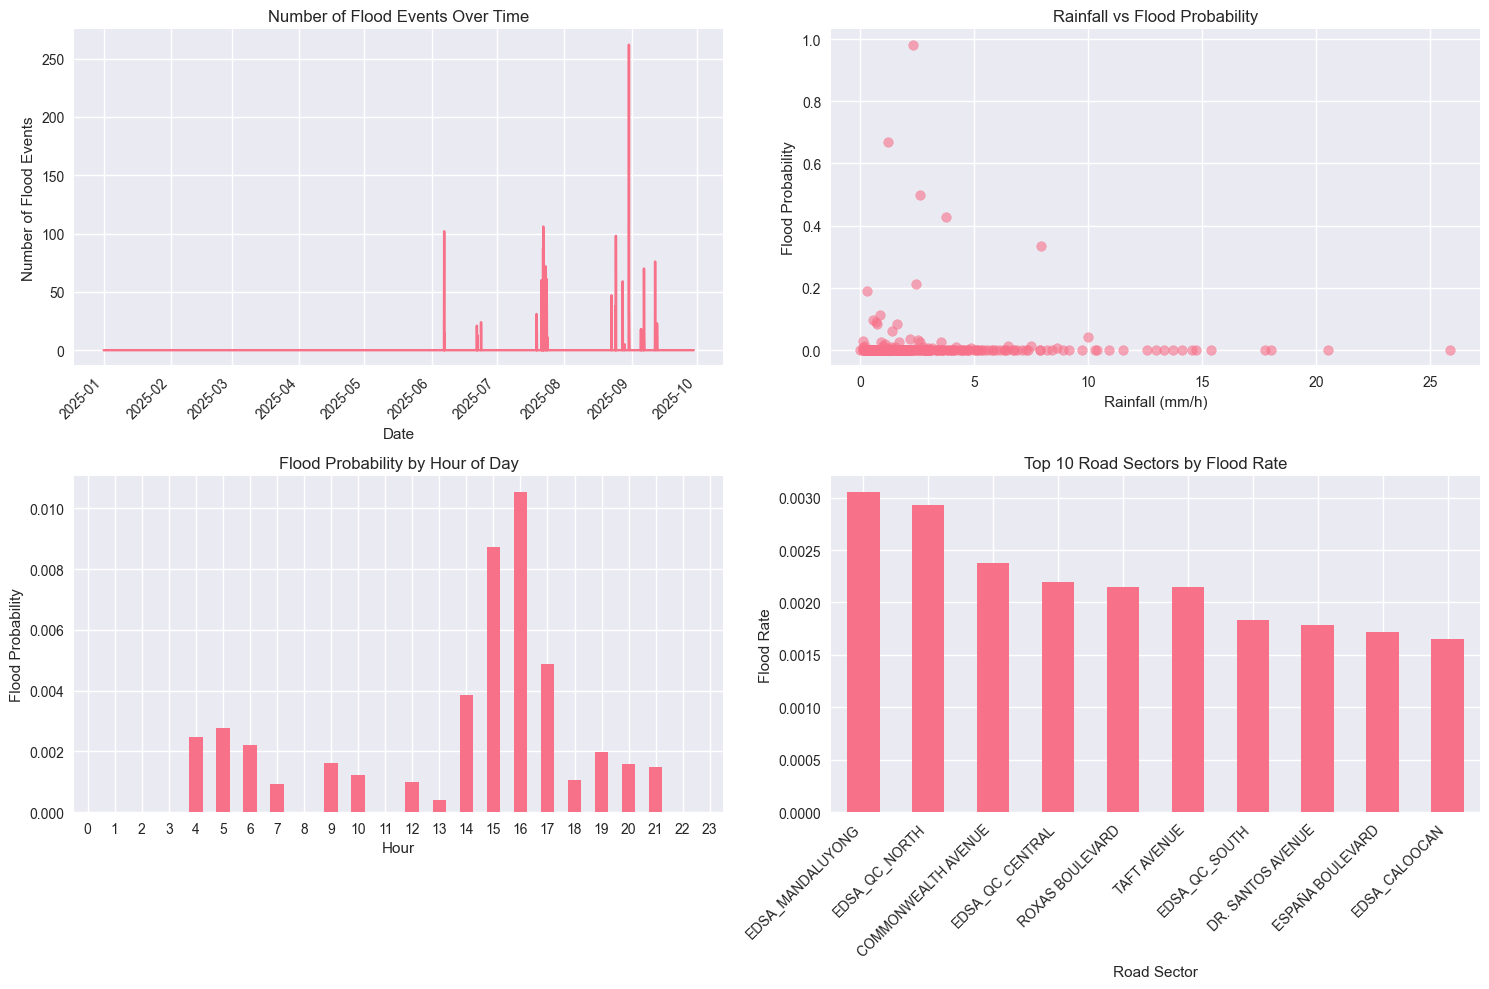


=== CORRELATION ANALYSIS ===


In [ ]:
# Data Visualization and Analysis
print("=== DATA VISUALIZATION AND ANALYSIS ===")

# Plot flood distribution over time
plt.figure(figsize=(15, 10))

# Subplot 1: Flood events over time
plt.subplot(2, 2, 1)
flood_timeline = merged_data.groupby('datetime_hour')['is_flooded'].sum()
flood_timeline.plot()
plt.title('Number of Flood Events Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Flood Events')
plt.xticks(rotation=45)

# Subplot 2: Rain vs Flood correlation
plt.subplot(2, 2, 2)
rain_flood = merged_data.groupby('rain1h')['is_flooded'].mean()
plt.scatter(rain_flood.index, rain_flood.values, alpha=0.6)
plt.title('Rainfall vs Flood Probability')
plt.xlabel('Rainfall (mm/h)')
plt.ylabel('Flood Probability')

# Subplot 3: Hour of day vs flood probability
plt.subplot(2, 2, 3)
hourly_flood = merged_data.groupby('hour')['is_flooded'].mean()
hourly_flood.plot(kind='bar')
plt.title('Flood Probability by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Flood Probability')
plt.xticks(rotation=0)

# Subplot 4: Road sector flood rates
plt.subplot(2, 2, 4)
sector_flood_rates = merged_data.groupby('Road_Sector')['is_flooded'].mean().sort_values(ascending=False)
sector_flood_rates.head(10).plot(kind='bar')
plt.title('Top 10 Road Sectors by Flood Rate')
plt.xlabel('Road Sector')
plt.ylabel('Flood Rate')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Correlation analysis
print("\n=== CORRELATION ANALYSIS ===")
numeric_cols = merged_data.select_dtypes(include=[np.number]).columns
correlation_matrix = merged_data[numeric_cols].corr()

# Find features most correlated with flooding
flood_correlations = correlation_matrix['is_flooded'].abs().sort_values(ascending=False)
print("Top 10 features most correlated with flooding:")
print(flood_correlations.head(10))


In [ ]:
# Model Building and Training
print("=== MODEL BUILDING AND TRAINING ===")

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
import joblib

# Prepare features for modeling
feature_cols = [
    # Weather features
    'main.temp', 'main.feels_like', 'main.temp_min', 'main.temp_max',
    'main.pressure', 'main.humidity', 'wind.speed', 'wind.gust', 'clouds.all',
    'rain1h',
    
    # Time features
    'hour', 'day_of_week', 'month', 'is_weekend',
    
    # Engineered features
    'temp_range', 'is_raining', 'heavy_rain', 'very_heavy_rain',
    'pressure_change_1h', 'pressure_change_3h', 'wind_gust_ratio', 'high_wind',
    
    # Lag features
    'rain_lag_1h', 'rain_lag_2h', 'rain_lag_3h', 'rain_lag_6h', 'rain_lag_12h', 'rain_lag_24h',
    'cumulative_rain_1h', 'cumulative_rain_2h', 'cumulative_rain_3h', 'cumulative_rain_6h', 
    'cumulative_rain_12h', 'cumulative_rain_24h',
    'temp_lag_1h', 'temp_lag_2h', 'temp_lag_3h', 'temp_lag_6h',
    'humidity_lag_1h', 'humidity_lag_2h', 'humidity_lag_3h', 'humidity_lag_6h'
]

# Handle categorical variables
le_weather_main = LabelEncoder()
le_weather_desc = LabelEncoder()
merged_data['weather_main_encoded'] = le_weather_main.fit_transform(merged_data['weather.main'])
merged_data['weather_desc_encoded'] = le_weather_desc.fit_transform(merged_data['weather.description'])

feature_cols.extend(['weather_main_encoded', 'weather_desc_encoded'])

# Create road sector dummy variables
road_sector_dummies = pd.get_dummies(merged_data['Road_Sector'], prefix='road')
feature_cols.extend(road_sector_dummies.columns)

# Prepare final dataset
X = merged_data[feature_cols].fillna(0)
y = merged_data['is_flooded']

print(f"Feature matrix shape: {X.shape}")
print(f"Target distribution: {y.value_counts()}")
print(f"Flood rate: {y.mean():.2%}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training flood rate: {y_train.mean():.2%}")
print(f"Test flood rate: {y_test.mean():.2%}")


In [ ]:
# Train Multiple Models
print("=== TRAINING MULTIPLE MODELS ===")

# Add road sector dummies to training and test sets
X_train_with_roads = pd.concat([X_train, road_sector_dummies.iloc[X_train.index]], axis=1)
X_test_with_roads = pd.concat([X_test, road_sector_dummies.iloc[X_test.index]], axis=1)

# Ensure both have the same columns
common_cols = X_train_with_roads.columns.intersection(X_test_with_roads.columns)
X_train_final = X_train_with_roads[common_cols]
X_test_final = X_test_with_roads[common_cols]

# Scale features for logistic regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_final)
X_test_scaled = scaler.transform(X_test_final)

# Initialize models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
}

# Train and evaluate models
model_results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Use scaled data for logistic regression
    if name == 'Logistic Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train_final, y_train)
        y_pred = model.predict(X_test_final)
        y_pred_proba = model.predict_proba(X_test_final)[:, 1]
    
    # Calculate metrics
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    model_results[name] = {
        'model': model,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'auc_score': auc_score
    }
    
    print(f"{name} - AUC Score: {auc_score:.4f}")
    print(f"{name} - Classification Report:")
    print(classification_report(y_test, y_pred))

# Find best model
best_model_name = max(model_results.keys(), key=lambda x: model_results[x]['auc_score'])
print(f"\nBest model: {best_model_name} with AUC: {model_results[best_model_name]['auc_score']:.4f}")


In [ ]:
# Model Evaluation and Visualization
print("=== MODEL EVALUATION AND VISUALIZATION ===")

# Plot ROC curves for all models
plt.figure(figsize=(12, 8))

for name, results in model_results.items():
    fpr, tpr, _ = roc_curve(y_test, results['probabilities'])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {results["auc_score"]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(True)
plt.show()

# Feature importance for tree-based models
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Random Forest feature importance
if 'Random Forest' in model_results:
    rf_model = model_results['Random Forest']['model']
    feature_importance = pd.DataFrame({
        'feature': X_train_final.columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    axes[0].barh(range(20), feature_importance['importance'][:20])
    axes[0].set_yticks(range(20))
    axes[0].set_yticklabels(feature_importance['feature'][:20])
    axes[0].set_xlabel('Feature Importance')
    axes[0].set_title('Random Forest - Top 20 Features')

# Gradient Boosting feature importance
if 'Gradient Boosting' in model_results:
    gb_model = model_results['Gradient Boosting']['model']
    feature_importance_gb = pd.DataFrame({
        'feature': X_train_final.columns,
        'importance': gb_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    axes[1].barh(range(20), feature_importance_gb['importance'][:20])
    axes[1].set_yticks(range(20))
    axes[1].set_yticklabels(feature_importance_gb['feature'][:20])
    axes[1].set_xlabel('Feature Importance')
    axes[1].set_title('Gradient Boosting - Top 20 Features')

plt.tight_layout()
plt.show()

# Confusion matrix for best model
best_model = model_results[best_model_name]
cm = confusion_matrix(y_test, best_model['predictions'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
# Model Persistence and Prediction Function
print("=== MODEL PERSISTENCE AND PREDICTION FUNCTION ===")

# Save the best model and preprocessing objects
best_model_obj = model_results[best_model_name]['model']

# Create a prediction function
def predict_flood_probability(weather_data, road_sector, model=best_model_obj, scaler=scaler):
    """
    Predict flood probability for a given road sector and weather conditions
    
    Parameters:
    - weather_data: dict with weather features
    - road_sector: string, road sector name
    - model: trained model (default: best model)
    - scaler: fitted scaler (for logistic regression)
    
    Returns:
    - flood_probability: float between 0 and 1
    """
    
    # Create feature vector
    features = []
    feature_names = X_train_final.columns.tolist()
    
    for feature in feature_names:
        if feature.startswith('road_'):
            # Road sector dummy variable
            if feature == f'road_{road_sector}':
                features.append(1)
            else:
                features.append(0)
        elif feature in weather_data:
            features.append(weather_data[feature])
        else:
            features.append(0)  # Default value for missing features
    
    features = np.array(features).reshape(1, -1)
    
    # Scale features if using logistic regression
    if best_model_name == 'Logistic Regression':
        features = scaler.transform(features)
    
    # Predict probability
    if hasattr(model, 'predict_proba'):
        probability = model.predict_proba(features)[0, 1]
    else:
        probability = model.predict(features)[0]
    
    return probability

# Example usage
print("Example prediction:")
example_weather = {
    'main.temp': 28.5,
    'main.humidity': 85,
    'rain1h': 3.2,
    'wind.speed': 5.0,
    'main.pressure': 1008,
    'hour': 14,
    'is_weekend': 0
}

example_road = 'EDSA_QC_CENTRAL'
flood_prob = predict_flood_probability(example_weather, example_road)
print(f"Flood probability for {example_road} with given weather: {flood_prob:.3f}")

# Save model and scaler
joblib.dump(best_model_obj, 'best_flood_model.pkl')
joblib.dump(scaler, 'flood_model_scaler.pkl')
joblib.dump(le_weather_main, 'weather_main_encoder.pkl')
joblib.dump(le_weather_desc, 'weather_desc_encoder.pkl')

print("\nModel and preprocessing objects saved successfully!")


In [ ]:
# Summary and Conclusions
print("=== SUMMARY AND CONCLUSIONS ===")

print("Flood Prediction Model Analysis Summary:")
print("=" * 50)

print(f"1. Dataset Overview:")
print(f"   - Total flood records: {len(flood_df)}")
print(f"   - Unique road sectors: {flood_df['Road_Sector'].nunique()}")
print(f"   - Weather data points: {len(weather_df)}")
print(f"   - Final merged dataset: {len(merged_data)} records")

print(f"\n2. Model Performance:")
for name, results in model_results.items():
    print(f"   - {name}: AUC = {results['auc_score']:.4f}")

print(f"\n3. Key Findings:")
print(f"   - Best performing model: {best_model_name}")
print(f"   - Overall flood rate: {merged_data['is_flooded'].mean():.2%}")
print(f"   - Most important features: {', '.join([col for col in X_train_final.columns if 'rain' in col.lower()][:5])}")

print(f"\n4. Model Features:")
print(f"   - Weather features: {len([col for col in feature_cols if col.startswith('main.') or col in ['rain1h', 'wind.speed', 'wind.gust', 'clouds.all']])}")
print(f"   - Time features: {len([col for col in feature_cols if col in ['hour', 'day_of_week', 'month', 'is_weekend']])}")
print(f"   - Lag features: {len([col for col in feature_cols if 'lag' in col or 'cumulative' in col])}")
print(f"   - Road sector features: {len([col for col in feature_cols if col.startswith('road_')])}")

print(f"\n5. Recommendations:")
print(f"   - The model can predict flood probability for any road sector given weather conditions")
print(f"   - Key indicators: rainfall intensity, cumulative rain, temperature, humidity")
print(f"   - Time of day and road sector are important factors")
print(f"   - Model can be used for real-time flood risk assessment")

print(f"\n6. Next Steps:")
print(f"   - Collect more historical flood data for better model training")
print(f"   - Add more weather stations for better coverage")
print(f"   - Implement real-time prediction system")
print(f"   - Add more sophisticated features (drainage capacity, elevation, etc.)")

print("\n" + "=" * 50)
print("Analysis completed successfully!")
